In [161]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../..')


%load_ext autoreload
%autoreload 2

%matplotlib inline  

import matplotlib.pyplot as plt 
import numpy as np


from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.polygon import orient
from shapely.affinity import scale, rotate, translate

from PIL import Image, ImageFont, ImageDraw

from joblib import dump, load

from tqdm.autonotebook import tqdm

from shared.nbs_helpers import draw_polys, draw_clusters, InParallelWithBar
from shared.utils import np_to_shapely, shapely_to_np



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.insert(0, '../pytorch-CycleGAN-and-pix2pix')

In [3]:
from data.base_dataset import get_params, get_transform
from options.train_options import TrainOptions
from torchvision.transforms.functional import to_tensor, to_pil_image

import argparse


parser = argparse.ArgumentParser()

opts = TrainOptions()
opts.initialize(parser)
opt, _ = parser.parse_known_args(['--dataroot', '.'])

opt.num_threads = 0
opt.dataset_mode = 'tx'
opt.batch_size = 4
opt.serial_batches = True
opt.box_cluster_data_version = 35
opt.box_cluster_dataset_version = 2
opt.noise_style_image = True
opt.num_patches = 8

opt



Namespace(batch_size=4, beta1=0.5, box_cluster_data_version=35, box_cluster_dataset_version=2, checkpoints_dir='./checkpoints', continue_train=False, crop_size=256, dataroot='.', dataset_mode='tx', direction='AtoB', display_env='main', display_freq=400, display_id=1, display_ncols=4, display_port=8097, display_server='http://localhost', display_winsize=256, epoch='latest', epoch_count=1, gan_mode='lsgan', gpu_ids='0', init_gain=0.02, init_type='normal', input_nc=3, load_iter=0, load_size=286, lr=0.0002, lr_decay_iters=50, lr_policy='linear', max_dataset_size=inf, model='cycle_gan', n_layers_D=3, name='experiment_name', ndf=64, netD='basic', netG='resnet_9blocks', ngf=64, niter=100, niter_decay=100, no_dropout=False, no_flip=False, no_html=False, noise_style_image=True, norm='instance', num_patches=8, num_threads=0, output_nc=3, phase='train', pool_size=50, preprocess='resize_and_crop', print_freq=100, save_by_iter=False, save_epoch_freq=5, save_latest_freq=5000, serial_batches=True, su

In [4]:
from data.tx_dataset import TxDataset

txds = TxDataset(opt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


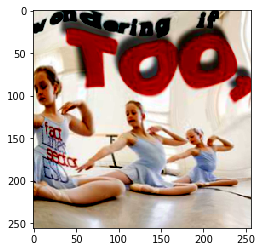

In [27]:
x = txds[123]
plt.imshow(x['style_img'].permute(1, 2, 0))

# Canny edge detection

In [ ]:
from shared.text import project_text
from shared.utils import shapely_to_np, np_to_shapely

# project_text()

from shared.datasets_v2 import compute_crop_and_cluster

ix = 128
img_path, crop, cluster = compute_crop_and_cluster(ix, txds.base_ds.main_boxes, txds.base_ds.boxes_lookup, border_size=txds.base_ds.border_size)

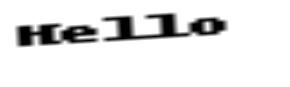

In [162]:
poly_np = cluster[0]
minx, miny, maxx, maxy = poly_np.envelope.bounds

img = project_text((int(maxx-minx), int(maxy-miny)), 'Hello', shapely_to_np(poly_np) - np.array([[minx-20, miny]]))
img = Image.fromarray(img)
img

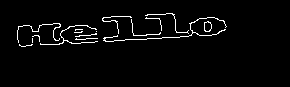

In [37]:
from skimage import feature

edges_img = feature.canny(np.array(img.convert('L'))/255, sigma=1) 

Image.fromarray(edges_img)


In [106]:
from skimage.morphology import square, dilation, binary_opening, binary_erosion, binary_closing
from skimage.measure import label
from skimage.color import label2rgb

from skimage.measure import label, regionprops

In [63]:
r = 21
selem = np.zeros((r, r))
selem[r//2,r//2:] = 1 


dilated_img_left = dilation(edges_img, selem)


selem = np.zeros((r, r))
selem[r//2,:1 + r//2] = 1 
dilated_img_right = dilation(edges_img, selem)

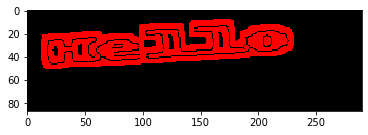

In [91]:

dilated_img = dilation(edges_img, square(10))



vis = np.stack([
    dilated_img ^ edges_img, 
    # edges_img, 
    # dilated_img_right
    np.zeros_like(edges_img),
    np.zeros_like(edges_img)
])

plt.imshow(vis.transpose(1, 2, 0).astype(int)*255)

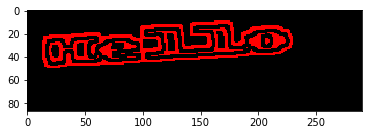

In [95]:
dilated_img = dilation(edges_img, square(10))
img = binary_erosion(dilated_img ^ edges_img, square(3))

vis = np.stack([
    # binary_opening(dilated_img ^ edges_img, square(4)), 
    img , 
    # edges_img, 
    # dilated_img_right
    np.zeros_like(edges_img),
    np.zeros_like(edges_img)
])

plt.imshow(vis.transpose(1, 2, 0).astype(int)*255)

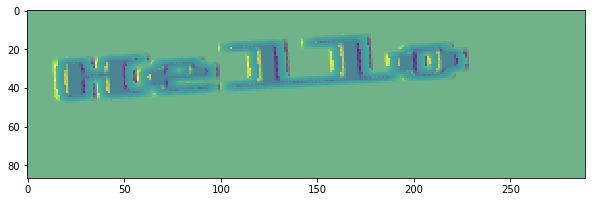

In [221]:
# img = binary_erosion(dilation(edges_img, square(17)) ^ dilation(edges_img, square(2)), square(3))

from skimage import feature

def create_tv_mask(img):
    edges_img = feature.canny(img, sigma=1) 
    mask = binary_erosion(dilation(edges_img, square(17)) ^ edges_img, square(3))
    return mask

img0 = np.array(img.convert('L'))/255

mask = create_tv_mask(img0)

# img = binary_closing(img, square(5))
# label_image = label(img, connectivity=1)

# image_label_overlay = label2rgb(label_image, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow((mask[:, :-1] & mask[:, 1:]))
ax.imshow((img0[:, :-1] - img0[:, 1:])*((mask[:, :-1] & mask[:, 1:])), alpha=0.8)
# ax.imshow((img0[:, :-1])*((mask[:, :-1] & mask[:, 1:])))
ax.imshow(img0[:, :-1], alpha=0.2)


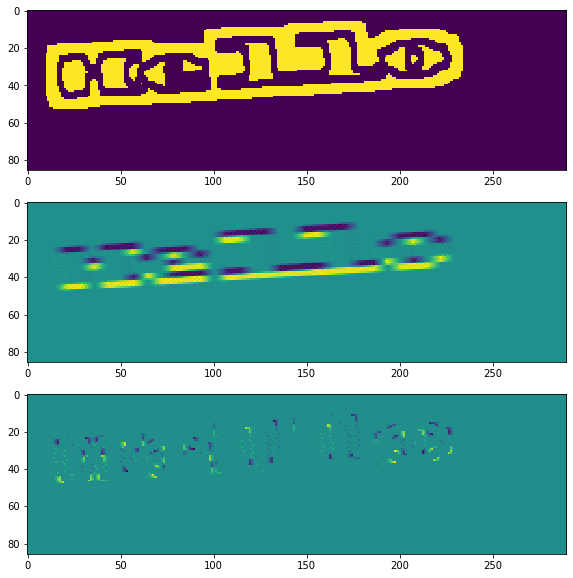

In [219]:
img0 = 1 - np.array(img.convert('L'))/255

fig, ax = plt.subplots(3, figsize=(10, 10))
ax = ax.ravel()



m = (mask[1:, :] & mask[:-1, :])

ax[0].imshow(m)
ax[1].imshow(img0[:-1, :] - img0[1:, :])
ax[2].imshow(img0[:-1, :]*m - img0[1:, :]*m)
# ax[1].imshow((img0[:-1, :] - img0[1:, :]), alpha=0.8)

# ax.imshow((img0[:, :-1])*((mask[:, :-1] & mask[:, 1:])))
# ax.imshow(m*( (1-img0[1:, :]) - (1-img0[:-1, :])))

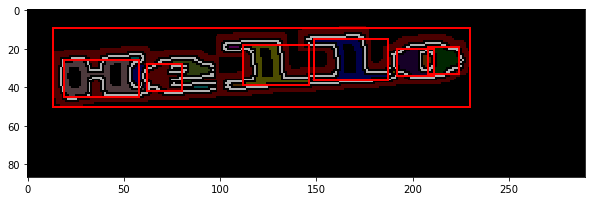

In [96]:
import matplotlib.patches as mpatches

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

In [121]:
from shared.nbs_helpers import build_dataset
import string

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse)).mean()


txds = build_dataset(val=True)

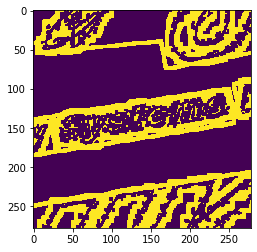

In [230]:
src_img, dst_img, bg_mask, masks, patch_edges, path, crop = txds.base_ds[0]
bg_mask = np.array(bg_mask)[:, :, np.newaxis]


from skimage.morphology import square, dilation, binary_opening, binary_erosion, binary_closing

tv_mask = ~(np.array(src_img) & ~bg_mask  | bg_mask)[:, :, 0]
tv_mask = binary_erosion(dilation(tv_mask, square(17)) ^ tv_mask, square(3))
tv_mask |= dilation(bg_mask[:, :, 0] & ~binary_erosion(bg_mask[:, :, 0], square(7)), square(3)).astype(bool)

plt.imshow(tv_mask)

In [227]:
np.array(src_img).shape

(278, 278, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


new


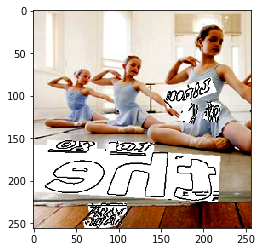

In [21]:
x = txds[128]
plt.imshow(x['A'].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


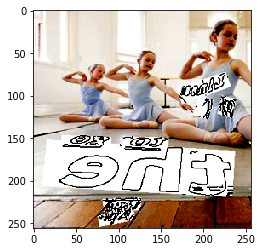

In [38]:
x = txds[128]
plt.imshow(x['A'].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


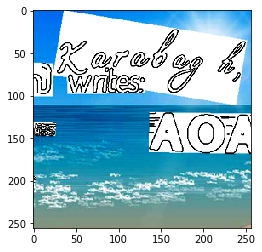

In [33]:
x = txds[5113]
plt.imshow(x['A'].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


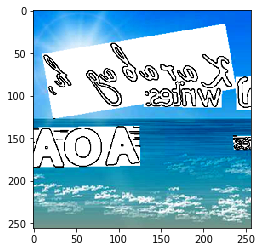

In [34]:
x = txds[5113]
plt.imshow(x['A'].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


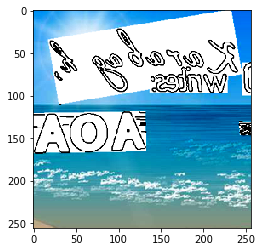

In [37]:
x = txds[5113]
plt.imshow(x['A'].permute(1, 2, 0))

# Distort style image

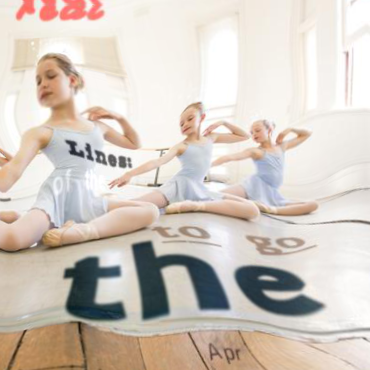

In [17]:

import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
# 

# x = txds[128]
# img = x['B'].permute(1, 2, 0).numpy()



img = np.array(txds.base_ds[128][1])

img = elastic_transform(img, img.shape[1]*5, img.shape[1]*0.08, img.shape[1]*0.008)
Image.fromarray(img)
# plt.imshow(img)
# list(x.keys())
